# Weather Prediction using LLMs

In [1]:
import re
import json
import requests
import pandas as pd

/tmp/ipykernel_4722/3512270941.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Functions to generate response using Ollama's REST API

In [10]:
def generate_response(model, question, format, seed=None):
    url = "http://localhost:11434/api/generate"
    
    if seed is not None:
        data = {
            "model": model,
            "prompt": question,
            "format": format,
            "options": {
                "seed": seed,
                "temperature": 0
              }
        }
    else:
        data = {
            "model": model,
            "prompt": question,
            "format": format,
        }
        
    
    response = requests.post(url, json=data)
    
    res_str = ''
    for r in response:
        res_str += r.decode('utf8')
    
    final_str = ''
    for s in res_str.split('\n'):
        if len(s) > 0:
            final_str += json.loads(s)['response'] 
    
    return final_str.strip()

question = 'What color is the sky at different times of the day? Respond using JSON'
print(generate_response('llama2', question, 'json'))

{
"morning": {
"color": "blue",
"intensity": 70
},
"noon": {
"color": "blue-gray",
"intensity": 85
},
"afternoon": {
"color": "white",
"intensity": 90
},
"evening": {
"color": "orange",
"intensity": 95
}
}


## Import CSV file (Delhi ITO)

In [4]:
df = pd.read_csv('Raw_data_1Day_2022_site_117_ITO_Delhi_CPCB_1Day.csv', parse_dates=['Timestamp'])
df.head()

,Timestamp,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),...,MP-Xylene (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),RF (mm),TOT-RF (mm),SR (W/mt2),BP (mmHg),VWS (m/s)
0,2022-01-01,208.84,254.51,32.20,26.86,40.47,28.74,14.13,2.42,13.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,240.99,304.71,35.10,28.88,43.90,28.13,15.78,1.95,13.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-03,211.72,265.12,33.08,28.23,41.64,28.63,15.42,1.54,15.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-04,168.09,213.67,39.08,31.68,48.46,28.41,18.60,2.71,13.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-05,213.47,251.85,50.86,39.47,62.35,26.66,14.23,3.32,10.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Taking only the first 5 parameters due to context length limitations (and many missing values in others)

In [5]:
df = df[df.columns[:6]]
columns = [col.split()[0] for col in df.columns[:6]]
df.columns = columns
df.head()

,Timestamp,PM2.5,PM10,NO,NO2,NOx
0,2022-01-01,208.84,254.51,32.20,26.86,40.47
1,2022-01-02,240.99,304.71,35.10,28.88,43.90
2,2022-01-03,211.72,265.12,33.08,28.23,41.64
3,2022-01-04,168.09,213.67,39.08,31.68,48.46
4,2022-01-05,213.47,251.85,50.86,39.47,62.35


## Define input prompt

In [8]:
input_prompt = f"""
You are an air quality expert. You will be given air quality data from the ITO station in Delhi. The task is to predict the next day's parameters given the present and previous day conditions. 

For example, if the input is:
{str(df.iloc[0:10]).strip()}

Then, the next 10 day's prediction will be:
{str(df.iloc[10:20].to_json()).strip()}

Find some kind of relation in the input values above to predict the next 10 day's parameters. If you cannot find a relation, make a guess.
{str(df.iloc[-110:-10]).strip()}

Respond using JSON
"""
print(input_prompt)


You are an air quality expert. You will be given air quality data from the ITO station in Delhi. The task is to predict the next day's parameters given the present and previous day conditions. 

For example, if the input is:
Timestamp   PM2.5    PM10     NO    NO2    NOx
0 2022-01-01  208.84  254.51  32.20  26.86  40.47
1 2022-01-02  240.99  304.71  35.10  28.88  43.90
2 2022-01-03  211.72  265.12  33.08  28.23  41.64
3 2022-01-04  168.09  213.67  39.08  31.68  48.46
4 2022-01-05  213.47  251.85  50.86  39.47  62.35
5 2022-01-06   78.05   98.38  22.55  24.32  31.27
6 2022-01-07   53.51   68.78  19.73  23.74  28.67
7 2022-01-08   37.17   41.53  16.76  23.12  25.93
8 2022-01-09   35.76   40.75  13.54  21.02  22.20
9 2022-01-10   62.57   80.63  17.56  22.27  26.13

Then, the next 10 day's prediction will be:
{"Timestamp":{"10":1641859200000,"11":1641945600000,"12":1642032000000,"13":1642118400000,"14":1642204800000,"15":1642291200000,"16":1642377600000,"17":1642464000000,"18":16425504000

## Model inference 

### Setting seed for reproducibility (sometimes formatting is not right)

In [40]:
llama2_pred = generate_response('llama2', input_prompt, format='json', seed=41)
llama2_pred = json.loads(llama2_pred)
llama2_pred = pd.DataFrame(llama2_pred)
llama2_pred

,PM2.5,PM10,NO,NO2,NOx
10,45.5,74.2,21.2,30.2,35.6
11,52.9,82.7,20.6,28.6,33.1
12,137.8,205.6,34.7,47.3,57.3
13,86.5,101.7,22.3,31.7,42.8
14,103.6,119.5,29.1,40.9,52.9
15,148.9,147.2,34.8,44.6,58.6
16,162.5,163.8,37.5,46.5,59.5
17,139.7,117.3,25.3,33.8,45.3
18,162.1,134.2,30.2,42.4,54.2
19,189.3,155.8,33.5,45.2,57.5


In [41]:
phi_pred = generate_response('phi', input_prompt, format='json', seed=100)
phi_pred = json.loads(phi_pred)
phi_pred = pd.DataFrame(phi_pred)
phi_pred

,Timestamp,PM2.5,PM10,NO,NO2,NOx
10,1641859200000,64.34,90.24,18.22,22.22,26.63
11,1641945600000,80.62,107.55,17.39,20.81,25.21
12,1642032000000,177.13,224.16,38.72,31.89,48.44
13,1642118400000,131.86,176.90,25.37,24.75,33.79
14,1642204800000,151.28,168.52,11.91,17.79,19.14
15,1642291200000,199.07,213.43,14.29,19.27,21.87
16,1642377600000,212.22,236.17,18.89,21.05,26.56
17,1642464000000,192.07,213.23,11.67,17.84,18.98
18,1642550400000,188.39,218.96,17.34,21.84,25.71
19,1642636800000,195.17,226.22,24.48,25.02,33.21


### Mistral has ongoing issue with json format output constraint (hangs indefinitely). [See here](https://github.com/ollama/ollama/issues/1910)
### Using regular format and then post-processing

In [66]:
mistral_pred = generate_response('mistral', input_prompt, format=None, seed=120)
print(mistral_pred)

Based on the given input data, it appears that there is no clear linear relationship between the current day's air quality parameters and the next day's parameters. However, some trends can be observed:

1. PM2.5 and PM10 levels tend to increase during winter months (December) compared to other seasons.
2. NO, NO2, and NOx levels tend to be higher in summer months (September) compared to other seasons.
3. There are some days where the air quality improves significantly from one day to the next, while on other days it worsens.

Given these observations, here is a guess for the next 10 day's parameters:

{"Timestamp":{"10":1642739200000,"11":1642835600000,"12":1642932000000,"13":1643028400000,"14":1643124800000,"15":1643221200000,"16":1643317600000,"17":1643414000000,"18":1643510400000,"19":1643606800000},"PM2.5":{ "10":30.0,"11":35.0,"12":40.0,"13":50.0,"14":60.0,"15":70.0,"16":80.0,"17":90.0,"18":100.0,"19":110.0},"PM10":{ "10":35.0,"11":40.0,"12":45.0,"13":65.0,"14":75.0,"15":85.0,"16

In [67]:
start = mistral_pred.find('{')
end = len(mistral_pred) - mistral_pred[::-1].find('}')
mistral_pred = mistral_pred[start-1:end]
mistral_pred = json.loads(mistral_pred.strip())
mistral_pred = pd.DataFrame(mistral_pred)
mistral_pred

,Timestamp,PM2.5,PM10,NO,NO2,NOx
10,1642739200000,30.0,35.0,15.0,20.0,25.0
11,1642835600000,35.0,40.0,12.0,18.0,23.0
12,1642932000000,40.0,45.0,20.0,30.0,45.0
13,1643028400000,50.0,65.0,30.0,40.0,50.0
14,1643124800000,60.0,75.0,35.0,45.0,55.0
15,1643221200000,70.0,85.0,40.0,50.0,60.0
16,1643317600000,80.0,95.0,45.0,55.0,65.0
17,1643414000000,90.0,105.0,50.0,60.0,70.0
18,1643510400000,100.0,115.0,55.0,65.0,75.0
19,1643606800000,110.0,125.0,60.0,70.0,80.0


## Evaluate metrics

In [68]:
from sklearn.metrics import mean_absolute_error

# ground truth values
gt = df.iloc[-10:]
gt

,Timestamp,PM2.5,PM10,NO,NO2,NOx
355,2022-12-22,146.57,211.85,163.50,69.56,169.80
356,2022-12-23,182.59,219.12,156.29,71.52,165.11
357,2022-12-24,163.03,182.81,130.69,55.16,135.59
358,2022-12-25,156.05,173.28,83.20,35.23,86.37
359,2022-12-26,168.56,181.22,115.87,51.99,121.85
360,2022-12-27,165.81,175.43,82.29,52.88,95.03
361,2022-12-28,129.53,134.78,85.27,45.46,93.51
362,2022-12-29,173.49,180.08,127.12,73.61,142.51
363,2022-12-30,202.05,207.68,202.56,67.89,203.46
364,2022-12-31,127.56,132.05,100.26,25.57,95.12


In [69]:
cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx']
def calc_mae(gt, pred):
    for col in cols:
        print(f"{col}: {mean_absolute_error(gt[col], pred[col])}")
    print(f"Overall: {mean_absolute_error(gt[cols], pred[cols])}")    

In [70]:
calc_mae(gt, llama2_pred)

PM2.5: 57.586
PM10: 64.742
NO: 95.785
NO2: 19.901000000000003
NOx: 81.155
Overall: 63.8338


In [71]:
calc_mae(gt, phi_pred)

PM2.5: 45.556999999999995
PM10: 56.88399999999999
NO: 104.877
NO2: 32.638999999999996
NOx: 102.88100000000001
Overall: 68.5676


In [72]:
calc_mae(gt, mistral_pred)

PM2.5: 95.024
PM10: 101.33
NO: 88.505
NO2: 21.335
NOx: 76.035
Overall: 76.44579999999999


## Visualize Results

In [83]:
import matplotlib
import matplotlib.pyplot as plt

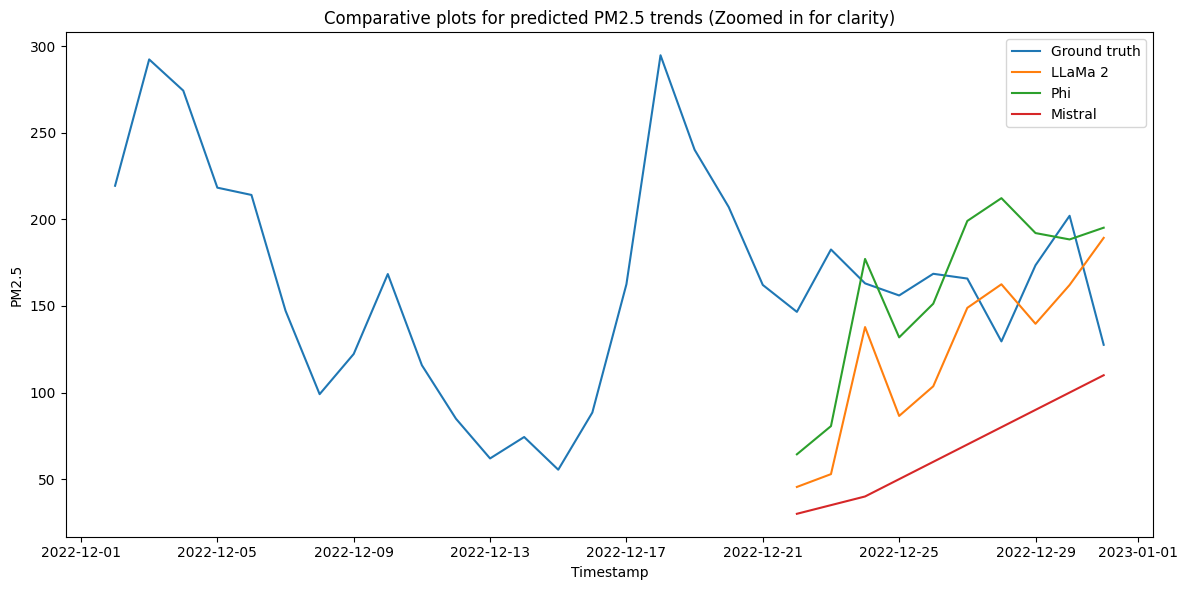

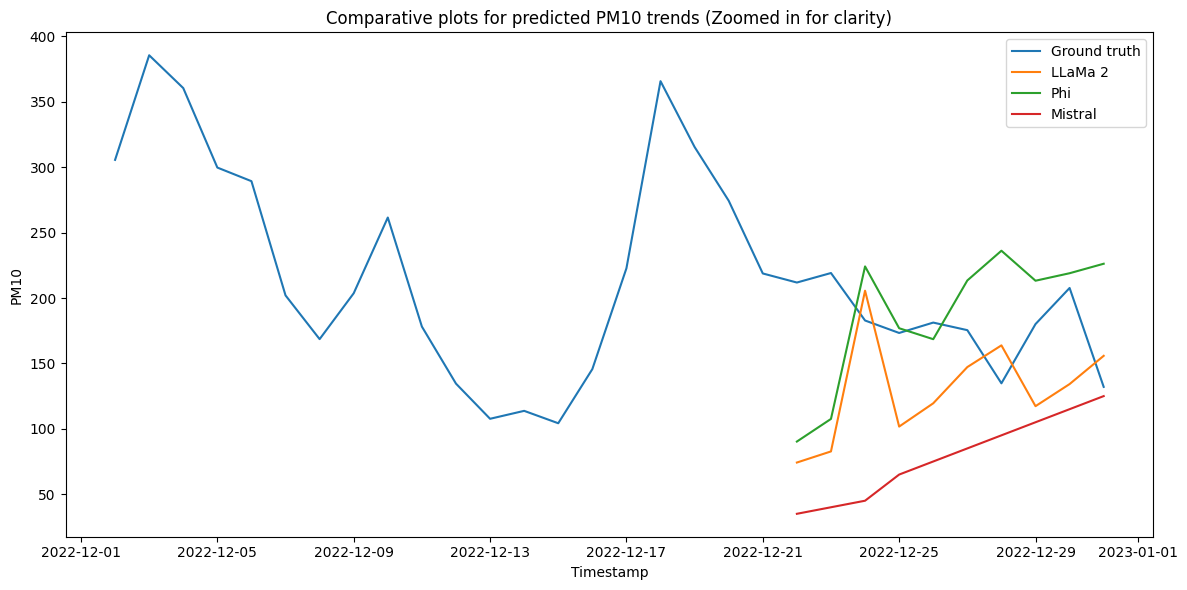

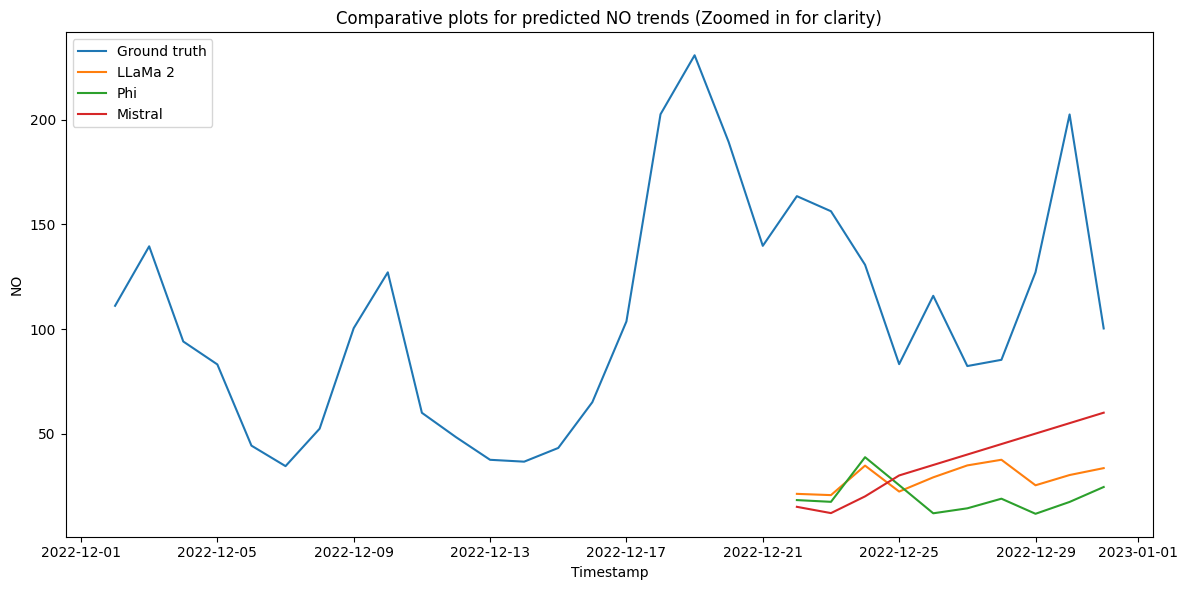

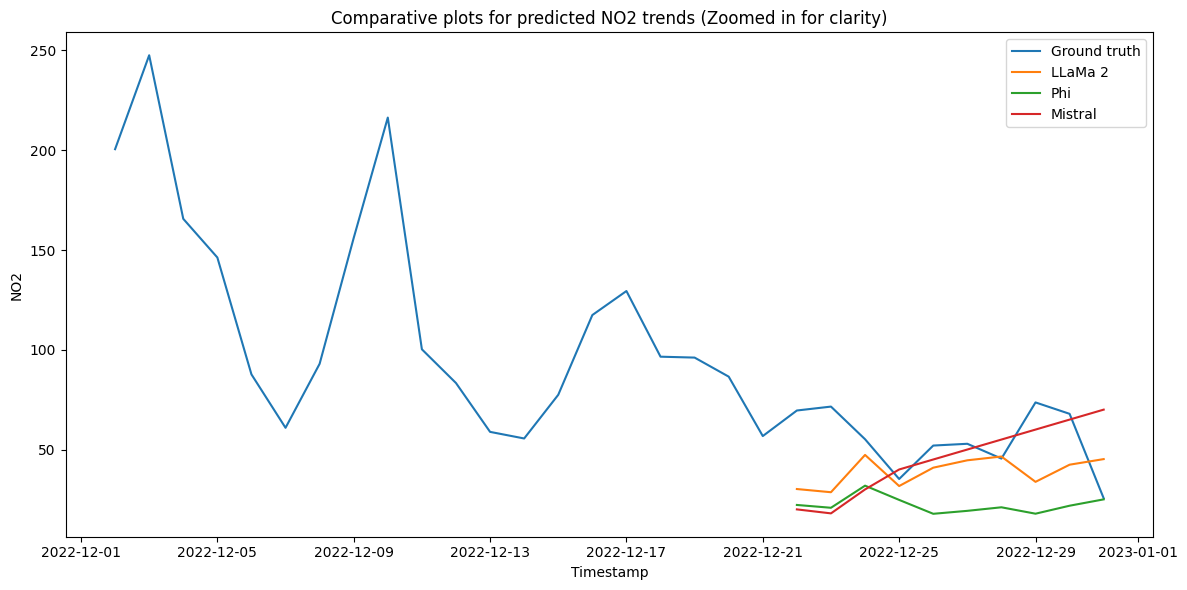

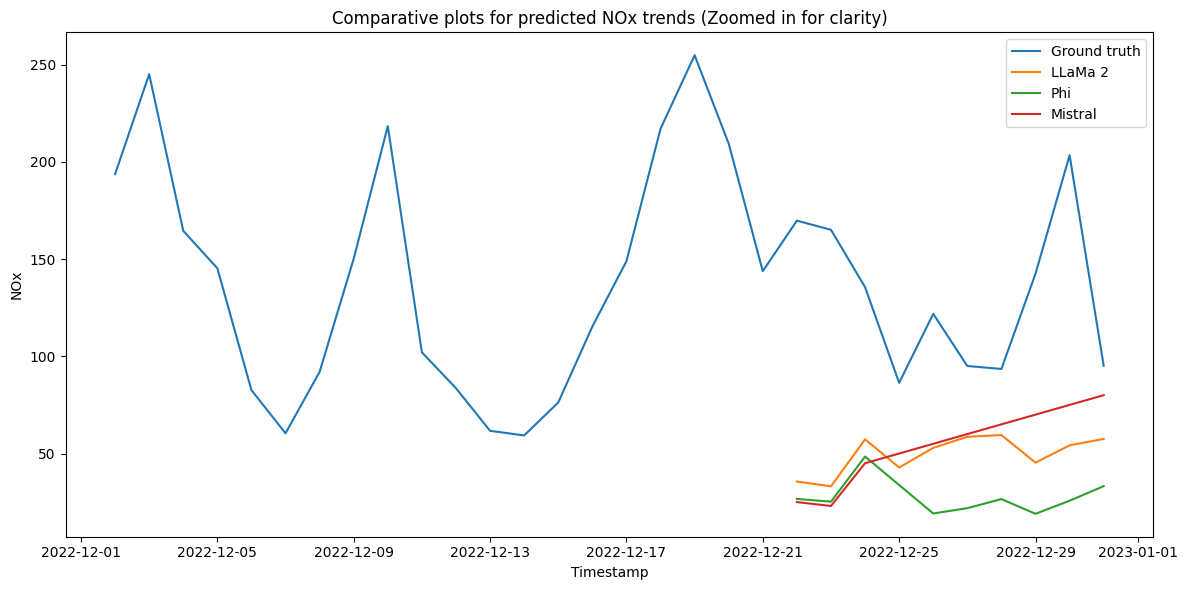

In [103]:
def plot_comparison(df, pred, col):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Timestamp'][-30:], df[col][-30:], label='Ground truth')
    plt.plot(df['Timestamp'][-10:], llama2_pred[col], label='LLaMa 2')
    plt.plot(df['Timestamp'][-10:], phi_pred[col], label='Phi')
    plt.plot(df['Timestamp'][-10:], mistral_pred[col], label='Mistral')
    plt.title(f'Comparative plots for predicted {col} trends (Zoomed in for clarity)')
    plt.legend()
    plt.xlabel('Timestamp')
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(f'plots/{col}.png')
    plt.show()

for col in cols:
    plot_comparison(df, llama2_pred, col)
    